In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from environment import Environment, DirectedTree, DEFAULT, CONSTITUENT
from prouter import Router

c:\users\albert\projekte\swmmpulse\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set plot-style to seaborn paper

In [9]:
#plt.style.use("ggplot")
plt.style.use("seaborn")
plt.style.use("seaborn-paper")

In [10]:
def preparation_env():
    env = Environment()
    #env.read_swmmoutfile(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp.out")
    env.read_swmmoutfile(r"demo_swmm_out.out")
    #graph = DirectedTree.from_swmm(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp.inp")
    graph = DirectedTree.from_swmm(r"demo_swmm-inp.inp")
    #node_data = pd.read_csv(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp/pop_node_data.csv")
    node_data = pd.read_csv(r"pop_node_data.csv")
    node_data = node_data.set_index("NAME").to_dict(orient="index")
    graph.add_nodevalues(node_data)
    env.add_graph(graph)
    return env

def set_infectivity(r_inf, env):
    env.information["groups"][0]["weight"] = 1 - r_inf
    env.information["groups"][1]["weight"] = r_inf
    return env

## Bristol defecation distribution

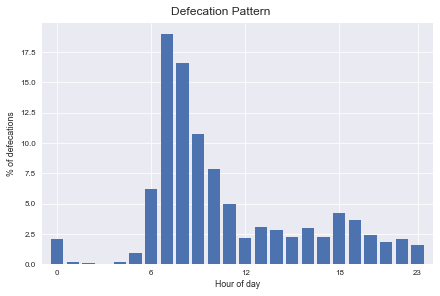

In [25]:
fig, ax = plt.subplots(figsize=[6,4], constrained_layout=True)
fig.suptitle("Defecation Pattern")


ax.set(xlabel="Hour of day", ylabel="% of defecations",
       xlim=[-1,24], xticks=[0, 6, 12, 18, 23])
ax.bar(x=np.arange(0,24), height=DEFAULT.PATTERN_BRISTOL)

plt.savefig(r"C:\Users\albert\Nextcloud\Documents\Doktorat\swmmPulse\paper\grafics\def_pat.svg")
plt.savefig(r"C:\Users\albert\Nextcloud\Documents\Doktorat\swmmPulse\paper\grafics\def_pat.png")

## Comparision dispersion fick / simplified

In [12]:
path = r"C:\Users\albert\Documents\SWMMpulse"
router = Router()
env = preparation_env()
groot = env.graph.root

cov = env.information["constituents"]["Cov-RNA"]
cov["fractions"] = [1]
cov["skewedness"] = [[1,1]]
env.information["constituents"]["Cov-RNA"] = cov

router.add_environment(env)

#generate packets
packets = router.environment.get_packets()

#generate routetable
routetable = router.route(packets=packets)

#calculate timeseries data at network root
processed = router.postprocess(routetable, packets, router.environment.information["constituents"].get(CONSTITUENT.COV))

#create dataframe
timeseries = pd.DataFrame(processed, index=pd.date_range("2000-01-01", freq="10S", periods=8640))
#calculate timeseries for entire catchment

In [13]:
try:
    packets.set_index("pid", inplace=True)
except:
    pass
packets["tm"] = pd.Series(routetable[groot])
packets["dt"] = packets["tm"] - packets["t0"]
packets["tm"] = packets["tm"] % 8640

packets =  packets.loc[(packets["classification"] == "infected")]
pmaxid = packets.loc[packets["dt"] == packets["dt"].max()].index
packets.loc[pmaxid]

,classification,origin,t0,constituents,tm,dt
pid,,,,,,
P58672,infected,MH4407705988,2744,None,491.724165,15027.724165


In [14]:
routetable[groot][pmaxid[0]]

17771.724164960182

### dispersion after fick

In [15]:
def disp_fick(tm, age):
    E = 0.16
    load = 1000
    
    link = env.graph.get_inletlinks(groot)[0]
    flow_velocity = env.flow_velocities.get(link)[tm]
    
    reduced_load = load * np.e**(-0.114*age/86400)
    
    date_range = np.arange(8640)
    delta_times = tm - date_range
    delta_dists = delta_times * flow_velocity * 10

    exponent = -(delta_dists**2)/(4*E*age)
    scalar = reduced_load/(2*np.sqrt(np.pi*E*age))

    concentrations_fick = scalar*np.e**exponent
    concentrations_fick = pd.Series(concentrations_fick, index=pd.date_range("01-01-2000 00:00", freq="10S", periods = 8640))
    return concentrations_fick

def disp_simp(tm, age):
    E = 0.16
    load = 1000
    
    date_range = np.arange(8640)
    
    concentrations_simp = np.zeros(len(date_range))
    d = 2 * (2 * E * age)**0.5 #m
    peak = reduced_load / d
    border = int(np.around(d / flow_velocity / 10)) #timesteps
    concentrations_simp[tm-border:tm] = np.linspace(0, peak, border)
    concentrations_simp[tm:tm+border] = np.linspace(peak, 0, border)
    concentrations_simp = pd.Series(concentrations_simp, index=pd.date_range("01-01-2000 00:00", freq="10S", periods = 8640))
    
    return concentrations_simp

In [16]:
tm = int(round(packets.loc[pmaxid,"tm"] % 8640, 0))
age = float(packets.loc[pmaxid,"dt"]) * 10
print(f"tm: {tm}, age: {age}")

link = env.graph.get_inletlinks(groot)[0]
flow_velocity = env.flow_velocities.get(link)[tm]
E = env.information["dispersion_rate"]
load = env.information["constituents"]["Cov-RNA"]["specific_load"]
reduced_load = load * np.e**(-env.information["constituents"]["Cov-RNA"]["decay_rate"]*age/86400)
print(f"load: {load}, reduced_load: {reduced_load}")

date_range = np.arange(8640)
delta_times = tm - date_range
delta_dists = delta_times * flow_velocity * 10 #10s

concentrations = np.zeros(8640)

exponent = -delta_dists**2/(4*E*age)
scalar = reduced_load/(2*np.sqrt(np.pi*E*age))
             
concentrations = scalar*np.e**exponent
concentrations = pd.Series(concentrations, index=pd.date_range("01-01-2000 00:00", freq="10S", periods = 8640))

tm: 492, age: 150277.2416496018
load: 1000, reduced_load: 820.1381546612564


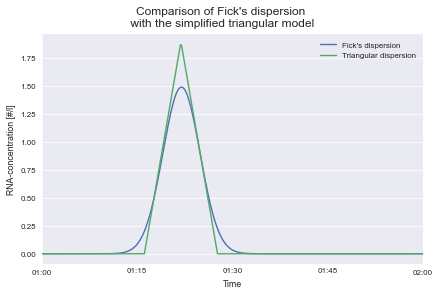

In [26]:
fig, ax = plt.subplots(figsize=[6,4], constrained_layout=True)
fig.suptitle("Comparison of Fick's dispersion\n with the simplified triangular model")

tm = int(round(packets.loc[pmaxid,"tm"] % 8640, 0))
age = float(packets.loc[pmaxid,"dt"]) * 10

#timeseries[pmaxid].plot(ax=ax)
disp_fick(tm, age).plot()
#concentrations.plot(ax=ax)
disp_simp(tm, age).plot()
ax.set(xlabel="Time", ylabel="RNA-concentration [#/l]")
indexer = concentrations.loc[concentrations != 0].index
#ax.set(xlim=[indexer[0], indexer[-1]])
ax.set(xlim=["01-01-2000 01:00", "01-01-2000 02:00"])
plt.legend(["Fick's dispersion","Triangular dispersion"])

plt.savefig(r"C:\Users\albert\Nextcloud\Documents\Doktorat\swmmPulse\paper\grafics\disp_comp.svg")
plt.savefig(r"C:\Users\albert\Nextcloud\Documents\Doktorat\swmmPulse\paper\grafics\disp_comp.png")

In [18]:
print(f"load ficks: {concentrations.sum() * 10 * flow_velocity}")
print(f"load simpl: {timeseries[pmaxid].sum().values[0] * 10 * flow_velocity}")
print(f"load simpl soll: {disp_simp(tm, age).sum() * 10 * flow_velocity}\n")
print(f"repr. load: {disp_simp(tm, age).sum()/concentrations.sum():.1%}")

load ficks: 820.1381546612563
load simpl: 820.9860697995632
load simpl soll: 820.9860697995632

repr. load: 100.1%
